In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (20, 15)
mpl.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.autograd import Variable

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import cv2

from PIL import Image
import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [5]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 250, done.
remote: Counting objects: 100% (250/250), done.
remote: Compressing objects: 100% (186/186), done.
remote: Total 3095 (delta 102), reused 197 (delta 64), pack-reused 2845
Receiving objects: 100% (3095/3095), 573.01 MiB | 46.51 MiB/s, done.
Resolving deltas: 100% (1206/1206), done.
Checking out files: 100% (891/891), done.


In [0]:
filepath = '/content/covid-chestxray-dataset/metadata.csv'
imagepath = '/content/covid-chestxray-dataset/images/'

In [7]:
data = pd.read_csv(filepath)
print(data.shape)

(673, 29)


In [8]:
data.head()

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 28
0,2,0.0,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [9]:
l = data['finding'].unique()
print(l)

['COVID-19' 'ARDS' 'SARS' 'Pneumocystis' 'Streptococcus' 'No Finding'
 'Chlamydophila' 'E.Coli' 'COVID-19, ARDS' 'Klebsiella' 'Legionella'
 'Pneumonia' 'Lipoid' 'Varicella' 'Bacterial'
 'Mycoplasma Bacterial Pneumonia' 'Influenza']


In [0]:
p_images = []
filename = []
for(i,row) in data.iterrows():
  if row["finding"] == "COVID-19" and row["view"]=="PA":
    filename.append(row["filename"])

for f in filename:
  p_images.append(imagepath+f)

In [0]:
p_images[0]

'/content/covid-chestxray-dataset/images/auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg'

In [0]:
path_normal = '/content/drive/My Drive/Colab Notebooks/normal'
normal_images = os.listdir(path_normal)
random.shuffle(normal_images)
n_images  = []
for i in range(len(p_images)):
  n_images.append(path_normal+'/'+normal_images[i])

In [0]:
n_images[76]

'/content/drive/My Drive/Colab Notebooks/normal/IM-0128-0001.jpeg'

In [0]:
#saving labels in a list
label = []
length = len(p_images)
Y= 2*length
for i in range(Y):                       #We are considering equal number of positive and negative cases
  label.append(1)

for i in range(int(Y/2)):
  label[i+int(Y/2)] = 0

In [0]:
imagepaths = []                         #appending paths of all images
for imag in p_images:
  imagepaths.append(imag)

for imag in n_images:
  imagepaths.append(imag)

In [0]:
classes = {1:'Corona',0:'Normal'}

In [0]:
classes[label[56]]

'Corona'

In [0]:
pretrained_size = 224
train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.Grayscale(3),
                           transforms.RandomResizedCrop(224),
                           transforms.RandomHorizontalFlip(),
                           transforms.ToTensor()
                       ])

In [0]:
class customdataset(Dataset):
  
  def __init__(self,imagepaths,labels,transform=None):
    self.imglist = imagepaths
    self.label = labels
    self.transform = transform                            #Dataset Class

  def __len__(self):
    return len(self.imglist)

  def __getitem__(self,index):
    image_path = self.imglist[index]
    im = Image.open(image_path).convert('RGB')
    im = self.transform(im)
    l = self.label[index]

    return im,l

In [0]:
dataset = customdataset(imagepaths,label,transform=train_transforms)

In [0]:
ratio = 0.8
n_train_examples = int(len(dataset) * ratio)
n_valid_examples = len(dataset) - n_train_examples

train,test = torch.utils.data.random_split(dataset, [n_train_examples, n_valid_examples])

val_ratio = 0.5
val_examples = int(len(test)*val_ratio)
test_examples = len(test)-val_examples

val,final_test = torch.utils.data.random_split(test,[val_examples,test_examples])

BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train,shuffle = True, batch_size = BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val,shuffle = True, batch_size = BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test,shuffle = True, batch_size = BATCH_SIZE)

In [0]:
def plot_images(images,label, classes,normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))                   #Plotting Images

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        
        label_t = classes[int(label[i])]
        ax.set_title(label_t)
        ax.axis('off')

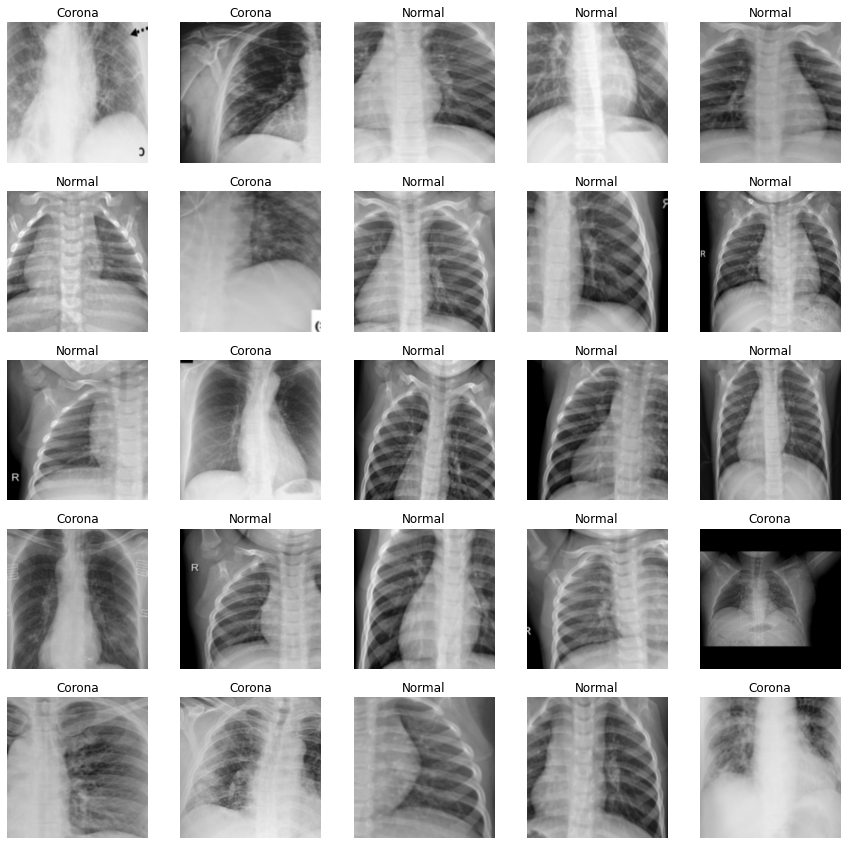

In [0]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train[i] for i in range(N_IMAGES)]])


plot_images(images, labels, classes)

In [0]:
use_gpu = torch.cuda.is_available()
resnet = models.resnet18(pretrained=True)
inputs, labels = next(iter(train))
if use_gpu:
    resnet = resnet.cuda()
                                  #A Residual neural network(ResNet18)    
else:
  print('Use GPU')
    
print(resnet.parameters)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [0]:
def train_model(dataloders, model, criterion, optimizer,num_epochs=10):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':                               #Training
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            i =0 
            for inputs, labels in dataloders[phase]:
                i=i+1
                if i%10==0:
                    print(i,"batches over")
                if use_gpu:
                    inputs, labels = Variable(inputs), Variable(labels)
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs.float().cuda())
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels.cuda())
                labels = labels.to('cpu')
                preds = preds.to('cpu')
                # print(preds)
                # print(labels)
                print((preds==labels.data))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data).item()
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()
        
        e.append(epoch)
        val_acc.append(valid_epoch_acc)
        val_loss.append(valid_epoch_loss)
        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [0]:
torch.cuda.empty_cache()

In [0]:
resnet = models.resnet18(pretrained=True)
# for training model parameters
for param in resnet.parameters():
    param.requires_grad = True

# new final classifer for output with 2 classes
num_ftrs = resnet.fc.in_features

resnet.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, num_ftrs),
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 2),
)

if use_gpu:
    resnet = resnet.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=2e-3,betas=(0.9, 0.99),weight_decay=0.0005)


dloaders = {'train':train_loader, 'valid':val_loader}

In [0]:
e = []
val_acc = []
val_loss = []
start_time = time.time()
model = train_model(dloaders, resnet, criterion, optimizer, num_epochs=10)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
tensor([ True, False, False,  True, False,  True,  True, False,  True,  True,
        False,  True, False, False, False, False, False, False,  True, False,
         True, False, False, False, False, False,  True,  True, False,  True,
        False, False])
tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])
tensor([ True,  True,  True,  True, False,  True,  True, False,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  T

**Best value Accuracy: 0.951220**

In [0]:
torch.save(resnet,'covidresnet.h5')

([<matplotlib.axis.YTick at 0x7f31e94b8b00>,
 <a list of 8 Text major ticklabel objects>)

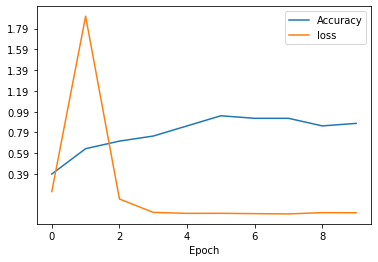

In [0]:
plt.plot(e,val_acc)
plt.plot(e,val_loss)
plt.legend(['Accuracy','loss'])
plt.xlabel('Epoch', fontsize=10)
plt.yticks(np.arange(min(val_acc), max(val_acc)+1, 0.2))